In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import classification_report, accuracy_score

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

## Step 1. Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 –target variables, the rest - predictors).

In [2]:
df = pd.read_csv('continuous dataset.csv')
df.head(10)

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
5,2015-01-03 06:00:00,879.2323,26.034143,0.019080,0.014542,20.062038,22.995081,0.017028,0.001485,9.087273,22.456018,0.016410,0.061539,5.280351,0,0,0
6,2015-01-03 07:00:00,932.4876,26.691492,0.019332,0.006645,21.623496,24.285242,0.017424,0.002176,11.395393,22.949304,0.016570,0.060898,5.126911,0,0,0
7,2015-01-03 08:00:00,1048.9720,27.674066,0.019370,0.006863,23.775317,26.189691,0.018073,0.004539,12.872866,24.088129,0.016677,0.056198,5.060611,0,0,0
8,2015-01-03 09:00:00,1167.9074,28.760400,0.019171,0.010231,24.636152,27.916650,0.018454,0.004292,14.548027,25.479150,0.016646,0.051071,4.915658,0,0,0
9,2015-01-03 10:00:00,1257.5069,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    48048 non-null  object 
 1   nat_demand  48048 non-null  float64
 2   T2M_toc     48048 non-null  float64
 3   QV2M_toc    48048 non-null  float64
 4   TQL_toc     48048 non-null  float64
 5   W2M_toc     48048 non-null  float64
 6   T2M_san     48048 non-null  float64
 7   QV2M_san    48048 non-null  float64
 8   TQL_san     48048 non-null  float64
 9   W2M_san     48048 non-null  float64
 10  T2M_dav     48048 non-null  float64
 11  QV2M_dav    48048 non-null  float64
 12  TQL_dav     48048 non-null  float64
 13  W2M_dav     48048 non-null  float64
 14  Holiday_ID  48048 non-null  int64  
 15  holiday     48048 non-null  int64  
 16  school      48048 non-null  int64  
dtypes: float64(13), int64(3), object(1)
memory usage: 6.2+ MB


In [4]:
df = df.drop(['datetime', 'W2M_toc', 'W2M_san', 'W2M_dav', 'Holiday_ID', 'holiday', 'school'], axis=1)

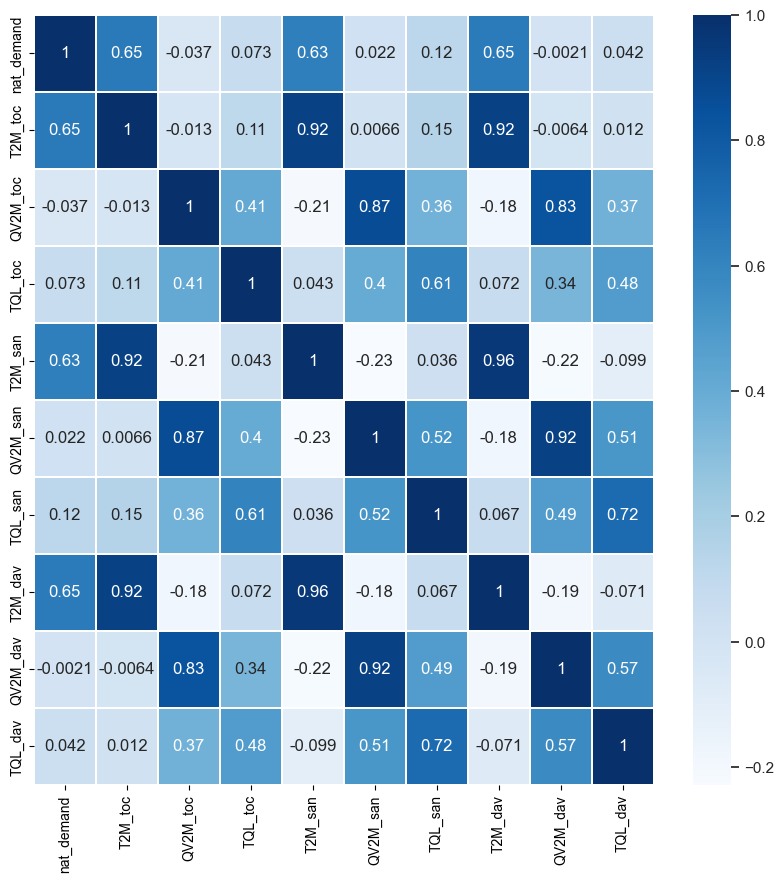

In [5]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df.corr(), cmap='Blues', annot=True, linewidths=0.25)

plt.show()

## Step 2. Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

In [6]:
sampled_df = df.sample(frac=0.5, random_state=0)

In [7]:
import scipy.stats

def inverse_ts(array, dist):
    args = dist.fit(array)
    data = np.random.uniform(size=len(array))
    its = dist(*args)
    its = its.ppf(data)
    return its

its_nat_demand = pd.DataFrame({'nat_demand': inverse_ts(df['nat_demand'], dist=scipy.stats.gamma)})
its_T2M_toc = pd.DataFrame({'T2M_toc': inverse_ts(df['T2M_toc'], dist=scipy.stats.gamma)})
its_T2M_san = pd.DataFrame({'T2M_san': inverse_ts(df['T2M_san'], dist=scipy.stats.gamma)})

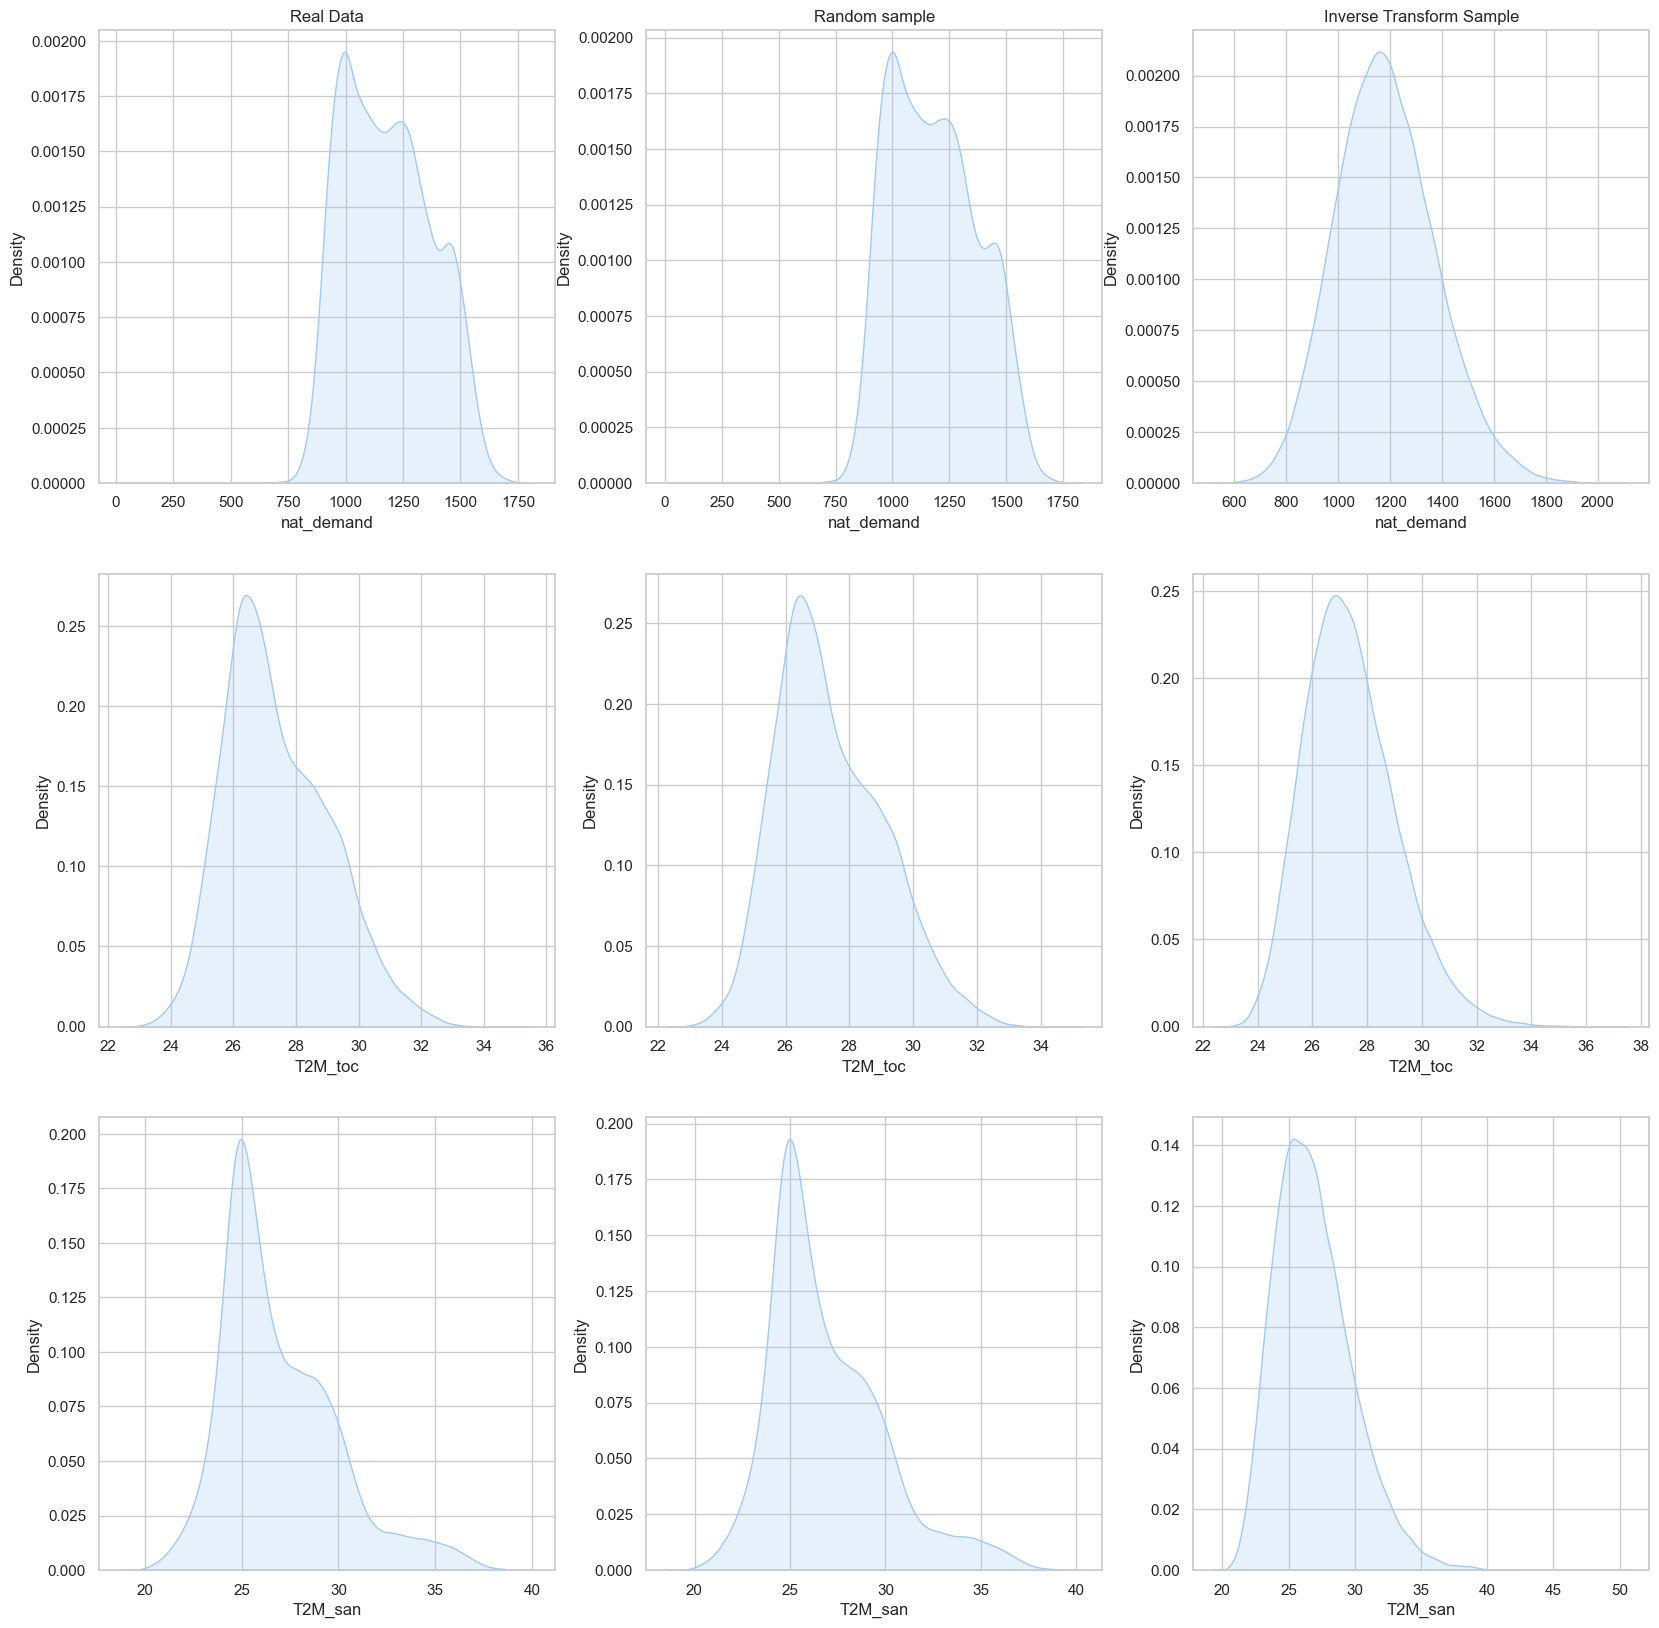

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Random sample')
ax[0, 2].set_title('Inverse Transform Sample')

sns.kdeplot(df['nat_demand'], ax=ax[0, 0], shade=True)
sns.kdeplot(sampled_df['nat_demand'], ax=ax[0, 1], shade=True)
sns.kdeplot(its_nat_demand['nat_demand'], ax=ax[0, 2], shade=True)

sns.kdeplot(df['T2M_toc'], ax=ax[1, 0], shade=True)
sns.kdeplot(sampled_df['T2M_toc'], ax=ax[1, 1], shade=True)
sns.kdeplot(its_T2M_toc['T2M_toc'], ax=ax[1, 2], shade=True)

sns.kdeplot(df['T2M_san'], ax=ax[2, 0], shade=True)
sns.kdeplot(sampled_df['T2M_san'], ax=ax[2, 1], shade=True)
sns.kdeplot(its_T2M_san['T2M_san'], ax=ax[2, 2], shade=True)

plt.show()

In [9]:
random_samp_df = pd.DataFrame(data={
    'nat_demand': sampled_df['nat_demand'],
    'T2M_toc': sampled_df['T2M_toc'],
    'T2M_san': sampled_df['T2M_san']
})

In [10]:
random_samp_df.mean()

nat_demand    1182.557391
T2M_toc         27.397559
T2M_san         26.916552
dtype: float64

In [11]:
random_samp_df.var()

nat_demand    36981.621056
T2M_toc           2.820489
T2M_san           9.155593
dtype: float64

In [12]:
its_df = pd.DataFrame(data={
    'nat_demand': its_nat_demand['nat_demand'],
    'T2M_toc': its_T2M_toc['T2M_toc'],
    'T2M_san': its_T2M_san['T2M_san']
})

In [13]:
its_df.mean()

nat_demand    1183.935630
T2M_toc         27.385148
T2M_san         26.912879
dtype: float64

In [14]:
its_df.var()

nat_demand    36718.684296
T2M_toc           2.809103
T2M_san           8.650621
dtype: float64

## Step 3. Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

<AxesSubplot:>

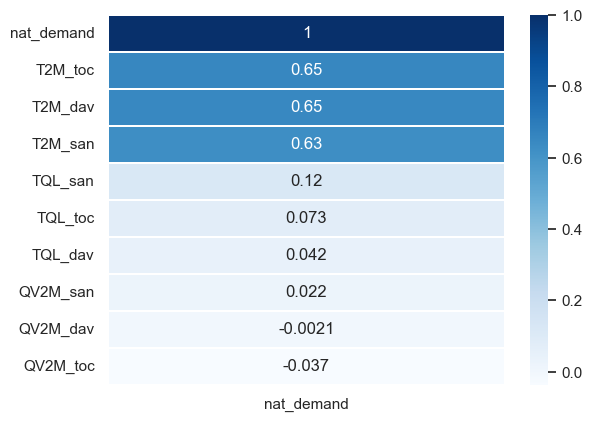

In [15]:
sns.heatmap(df.corr()[['nat_demand']].sort_values(by='nat_demand', ascending=False), cmap='Blues', annot=True, linewidths=0.25)

<AxesSubplot:>

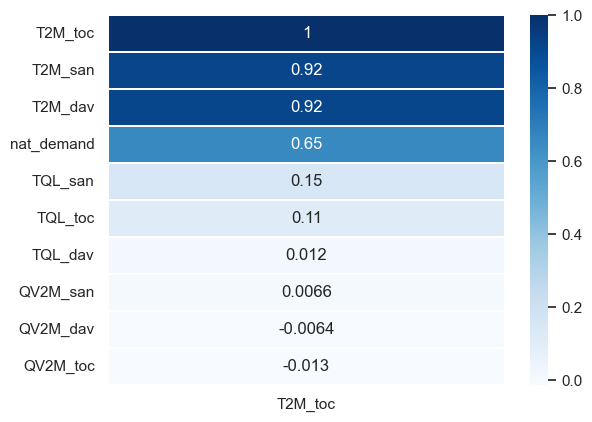

In [16]:
sns.heatmap(df.corr()[['T2M_toc']].sort_values(by='T2M_toc', ascending=False), cmap='Blues', annot=True, linewidths=0.25)

<AxesSubplot:>

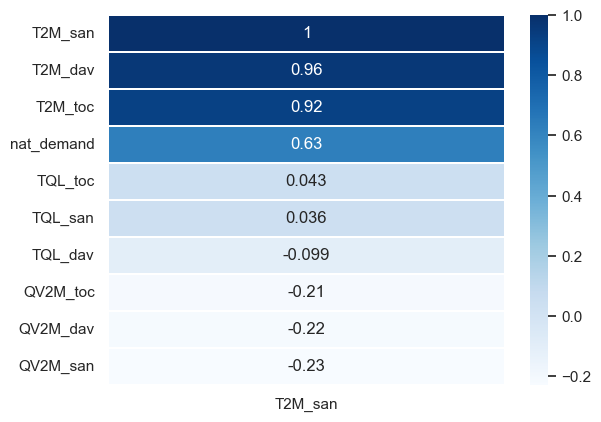

In [17]:
sns.heatmap(df.corr()[['T2M_san']].sort_values(by='T2M_san', ascending=False), cmap='Blues', annot=True, linewidths=0.25)

## Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [18]:
def create_edges(connections):

    edges = []
    for outlet, inlet in connections.items():
        for inl in inlet:
            edges.append([outlet, inl])
  
    return edges

connections = {
    'nat_demand': [],
    'T2M_toc': ['nat_demand'],
    'T2M_san': ['nat_demand', 'T2M_toc'],
    'QV2M_toc': [],
    'TQL_toc': [],
    'QV2M_san': ['QV2M_toc'], 
    'TQL_san': ['TQL_toc', 'QV2M_san'],
    'T2M_dav': ['nat_demand'],
    'QV2M_dav': ['QV2M_toc', 'QV2M_san', 'TQL_san'], 
    'TQL_dav': ['TQL_toc', 'QV2M_san', 'QV2M_dav']
}

edges = create_edges(connections)
vertices = ['nat_demand', 'T2M_toc', 'T2M_san', 'T2M_dav', 'TQL_san']
bn = {"V":vertices, "E":edges}

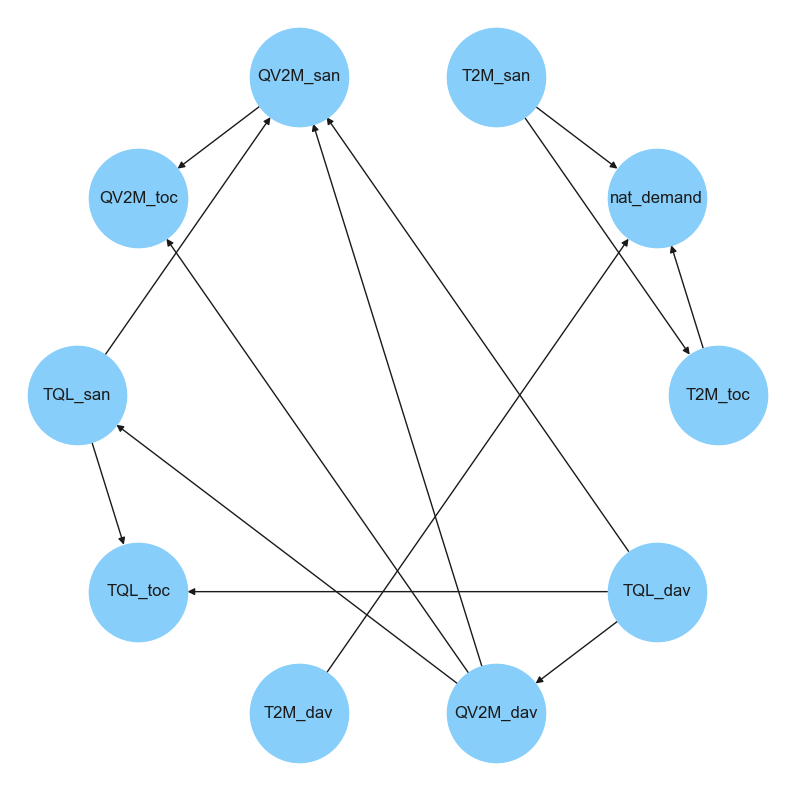

In [19]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(BayesianModel(edges).edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

## Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

In [20]:
df_transformed = df.copy()
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(df.values[:])
df_transformed[:] = df_discretized
df_transformed

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,T2M_san,QV2M_san,TQL_san,T2M_dav,QV2M_dav,TQL_dav
0,2.0,1.0,6.0,0.0,1.0,5.0,0.0,1.0,5.0,2.0
1,1.0,2.0,6.0,0.0,1.0,5.0,0.0,1.0,5.0,2.0
2,1.0,2.0,6.0,0.0,1.0,5.0,0.0,1.0,5.0,1.0
3,1.0,2.0,6.0,0.0,1.0,5.0,0.0,1.0,5.0,1.0
4,1.0,2.0,6.0,0.0,0.0,5.0,0.0,1.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...
48043,4.0,4.0,8.0,2.0,3.0,8.0,3.0,2.0,8.0,3.0
48044,4.0,3.0,8.0,2.0,2.0,8.0,4.0,2.0,8.0,4.0
48045,4.0,3.0,9.0,2.0,2.0,8.0,4.0,2.0,8.0,3.0
48046,3.0,3.0,9.0,2.0,2.0,8.0,3.0,2.0,8.0,3.0


In [21]:
def accuracy_params_restoration(bn, data):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param].copy()
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element, show_progress=False)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [22]:
hc_search = HillClimbSearch(data=df_transformed)
hc_k2 = hc_search.estimate(scoring_method=K2Score(df_transformed))
hc_bic = hc_search.estimate(scoring_method=BicScore(df_transformed))

  0%|          | 13/1000000 [00:00<18:29:08, 15.03it/s]


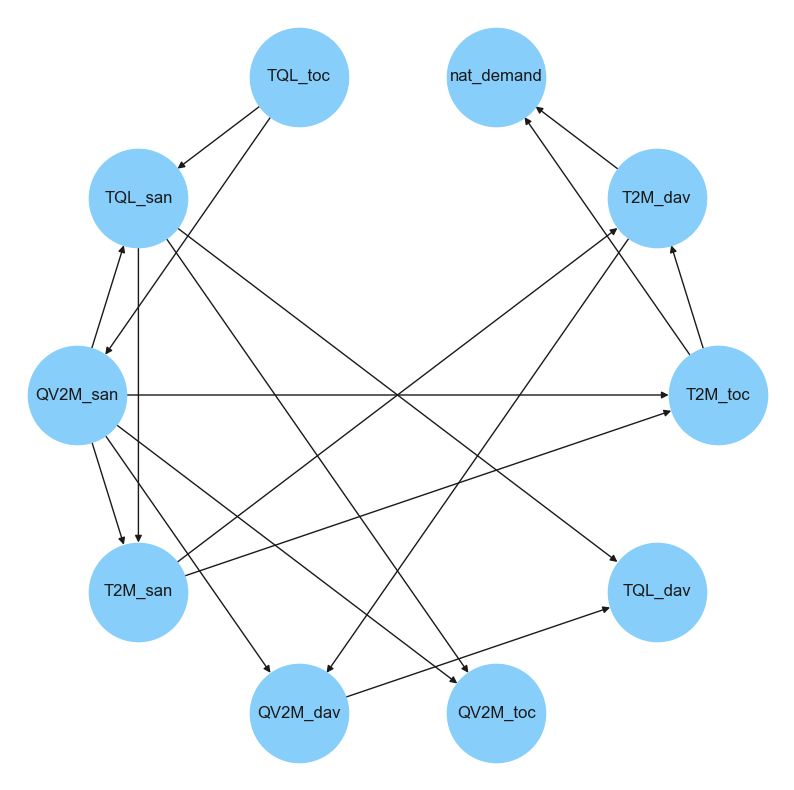

In [23]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_k2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

In [24]:
accuracy_params_restoration(BayesianNetwork(hc_k2.edges()),
                            df_transformed[:].sample(frac=0.01))

,Parameter,accuracy
0,nat_demand,0.3875
1,T2M_toc,0.683333
2,QV2M_toc,0.477083
3,TQL_toc,0.43125
4,T2M_san,0.7875
5,QV2M_san,0.866667
6,TQL_san,0.752083
7,T2M_dav,0.779167
8,QV2M_dav,0.702083
9,TQL_dav,0.435417


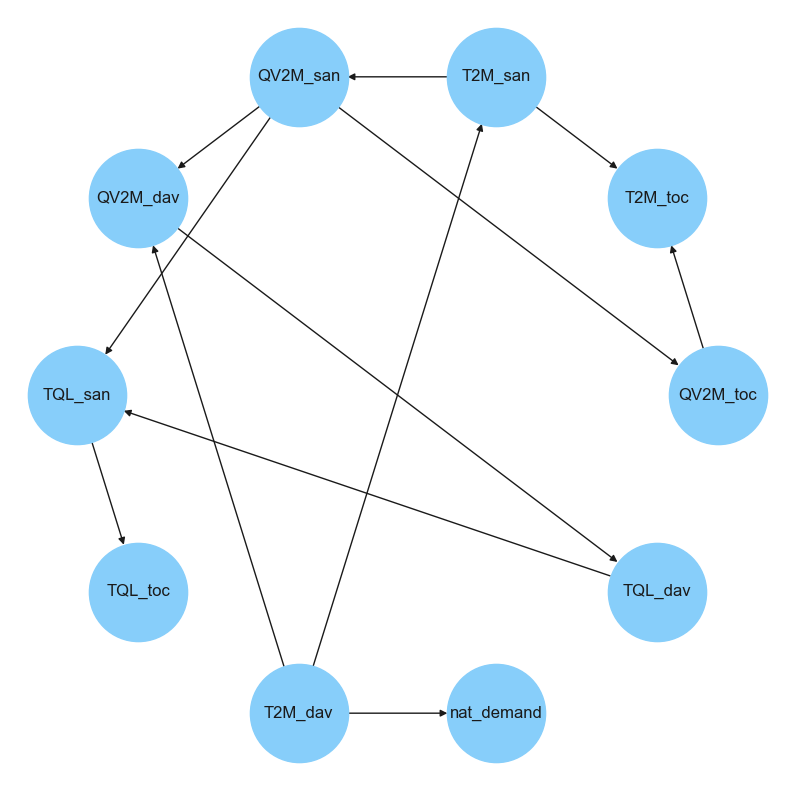

In [25]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

In [26]:
accuracy_params_restoration(BayesianNetwork(hc_bic.edges()),
                            df_transformed[:].sample(frac=0.01))

,Parameter,accuracy
0,nat_demand,0.277083
1,T2M_toc,0.583333
2,QV2M_toc,0.454167
3,TQL_toc,0.333333
4,T2M_san,0.7375
5,QV2M_san,0.764583
6,TQL_san,0.533333
7,T2M_dav,0.702083
8,QV2M_dav,0.591667
9,TQL_dav,0.45


In [27]:
e_search = TreeSearch(data=df_transformed)
e_model = e_search.estimate()

Building tree: 100%|██████████| 45/45.0 [00:00<00:00, 835.31it/s]


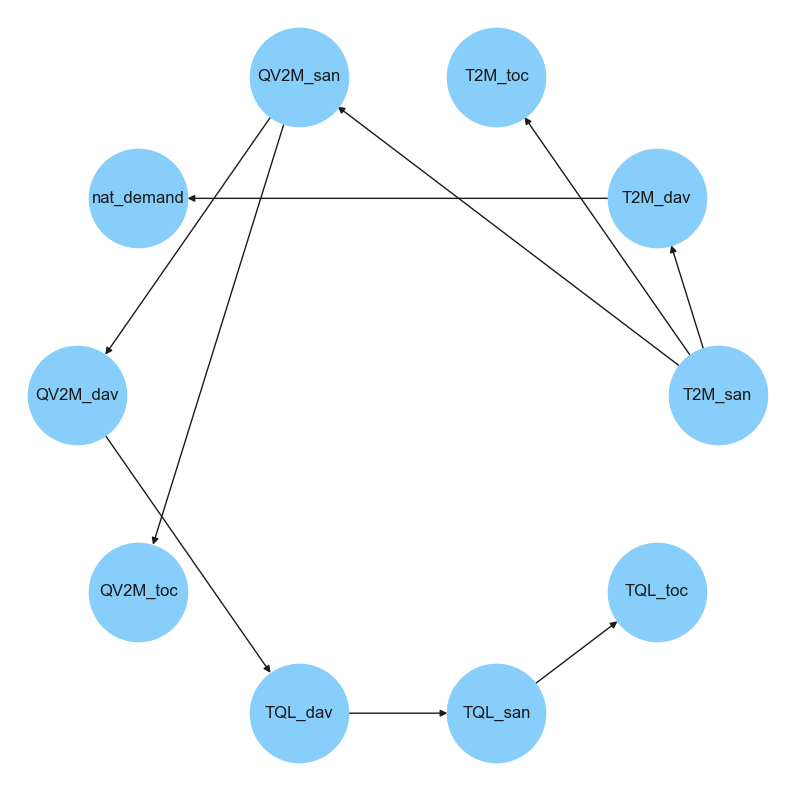

In [28]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(e_model.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

##  Step 6

In [29]:
def sampling (bn, data, n):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [30]:
def draw_comparative_hist (parametr, original_data, data_sampled, axes=None):
    final_df = pd.DataFrame()
    
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    
    sns.barplot(ax=axes, x=parametr, y="Probability", hue="Data", data=final_df, palette='Blues')

In [31]:
sample_K2 = sampling(hc_k2, df_transformed, df_transformed.shape[0])
sample_Bic = sampling(hc_bic, df_transformed, df_transformed.shape[0])

Generating for node: TQL_toc: 100%|██████████| 10/10 [00:00<00:00, 32.44it/s]


In [32]:
print(classification_report(df_transformed.nat_demand, sample_K2.nat_demand))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.07      0.07      0.07      2935
         2.0       0.13      0.13      0.13      5997
         3.0       0.13      0.13      0.13      6438
         4.0       0.13      0.13      0.13      6233
         5.0       0.13      0.13      0.13      6229
         6.0       0.14      0.14      0.14      6543
         7.0       0.12      0.12      0.12      5533
         8.0       0.10      0.10      0.10      5101
         9.0       0.07      0.07      0.07      3031

    accuracy                           0.12     48048
   macro avg       0.10      0.10      0.10     48048
weighted avg       0.12      0.12      0.12     48048



In [33]:
print(classification_report(df_transformed.nat_demand, sample_Bic.nat_demand))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.06      0.06      0.06      2935
         2.0       0.13      0.14      0.13      5997
         3.0       0.13      0.13      0.13      6438
         4.0       0.13      0.13      0.13      6233
         5.0       0.13      0.13      0.13      6229
         6.0       0.14      0.14      0.14      6543
         7.0       0.11      0.12      0.11      5533
         8.0       0.11      0.11      0.11      5101
         9.0       0.06      0.06      0.06      3031

    accuracy                           0.12     48048
   macro avg       0.10      0.10      0.10     48048
weighted avg       0.12      0.12      0.12     48048



In [34]:
print(classification_report(df_transformed.T2M_toc, sample_K2.T2M_toc))

              precision    recall  f1-score   support

         0.0       0.06      0.06      0.06      2655
         1.0       0.12      0.12      0.12      6249
         2.0       0.18      0.18      0.18      8447
         3.0       0.16      0.16      0.16      7892
         4.0       0.12      0.12      0.12      6059
         5.0       0.11      0.11      0.11      5333
         6.0       0.11      0.11      0.11      4672
         7.0       0.07      0.07      0.07      3692
         8.0       0.04      0.04      0.04      2159
         9.0       0.02      0.02      0.02       890

    accuracy                           0.12     48048
   macro avg       0.10      0.10      0.10     48048
weighted avg       0.12      0.12      0.12     48048



In [35]:
print(classification_report(df_transformed.T2M_toc, sample_Bic.T2M_toc))

              precision    recall  f1-score   support

         0.0       0.06      0.06      0.06      2655
         1.0       0.13      0.13      0.13      6249
         2.0       0.17      0.17      0.17      8447
         3.0       0.16      0.15      0.16      7892
         4.0       0.12      0.12      0.12      6059
         5.0       0.10      0.11      0.10      5333
         6.0       0.10      0.10      0.10      4672
         7.0       0.08      0.08      0.08      3692
         8.0       0.04      0.04      0.04      2159
         9.0       0.02      0.02      0.02       890

    accuracy                           0.12     48048
   macro avg       0.10      0.10      0.10     48048
weighted avg       0.12      0.12      0.12     48048



In [36]:
print(classification_report(df_transformed.T2M_san, sample_K2.T2M_san))

              precision    recall  f1-score   support

         0.0       0.06      0.06      0.06      2478
         1.0       0.15      0.15      0.15      7397
         2.0       0.22      0.22      0.22     10530
         3.0       0.16      0.16      0.16      7610
         4.0       0.13      0.13      0.13      5931
         5.0       0.11      0.11      0.11      5558
         6.0       0.08      0.08      0.08      4192
         7.0       0.04      0.04      0.04      1826
         8.0       0.03      0.04      0.04      1481
         9.0       0.02      0.02      0.02      1045

    accuracy                           0.14     48048
   macro avg       0.10      0.10      0.10     48048
weighted avg       0.14      0.14      0.14     48048



In [37]:
print(classification_report(df_transformed.T2M_san, sample_Bic.T2M_san))

              precision    recall  f1-score   support

         0.0       0.05      0.05      0.05      2478
         1.0       0.16      0.16      0.16      7397
         2.0       0.22      0.21      0.22     10530
         3.0       0.16      0.17      0.16      7610
         4.0       0.12      0.12      0.12      5931
         5.0       0.11      0.11      0.11      5558
         6.0       0.09      0.08      0.09      4192
         7.0       0.05      0.05      0.05      1826
         8.0       0.03      0.02      0.03      1481
         9.0       0.02      0.02      0.02      1045

    accuracy                           0.14     48048
   macro avg       0.10      0.10      0.10     48048
weighted avg       0.14      0.14      0.14     48048



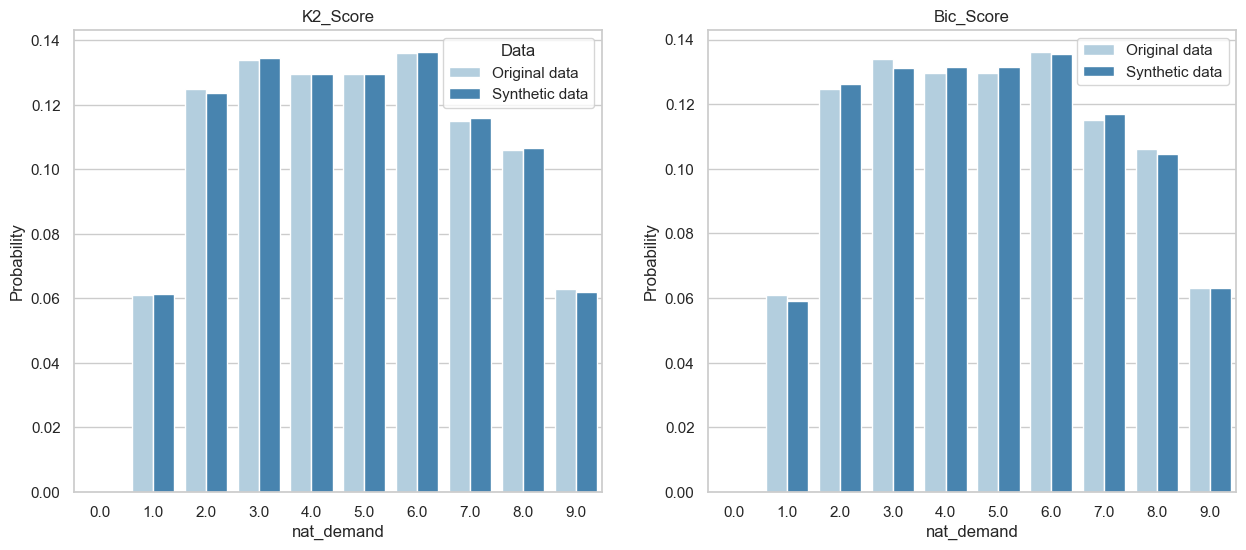

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

draw_comparative_hist('nat_demand', df_transformed, sample_K2, axes=axes[0])
draw_comparative_hist('nat_demand', df_transformed, sample_Bic, axes=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

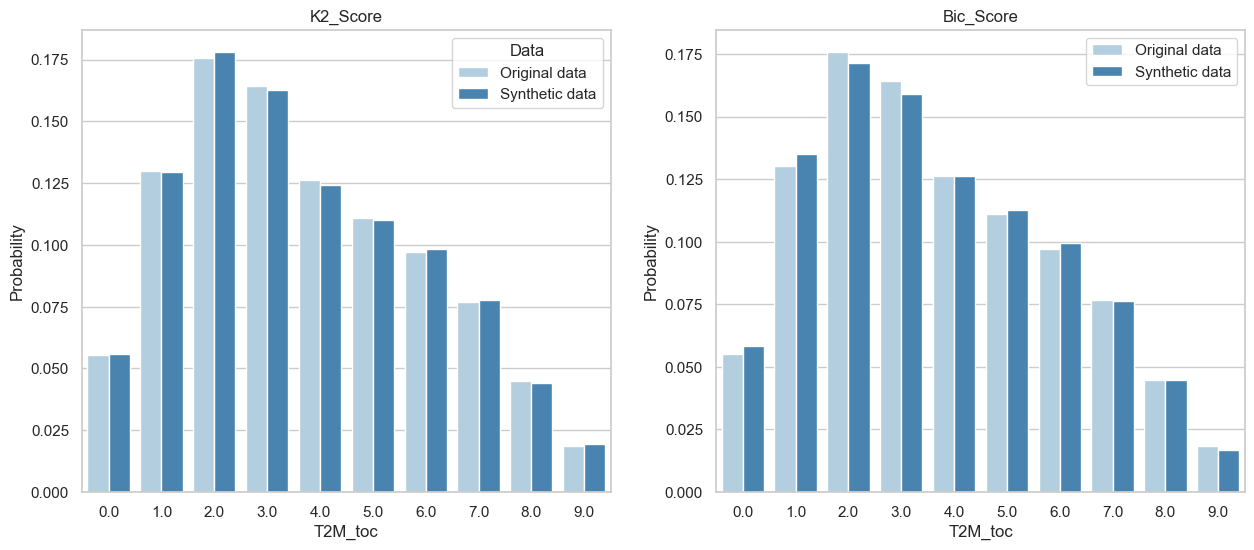

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

draw_comparative_hist('T2M_toc', df_transformed, sample_K2, axes=axes[0])
draw_comparative_hist('T2M_toc', df_transformed, sample_Bic, axes=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

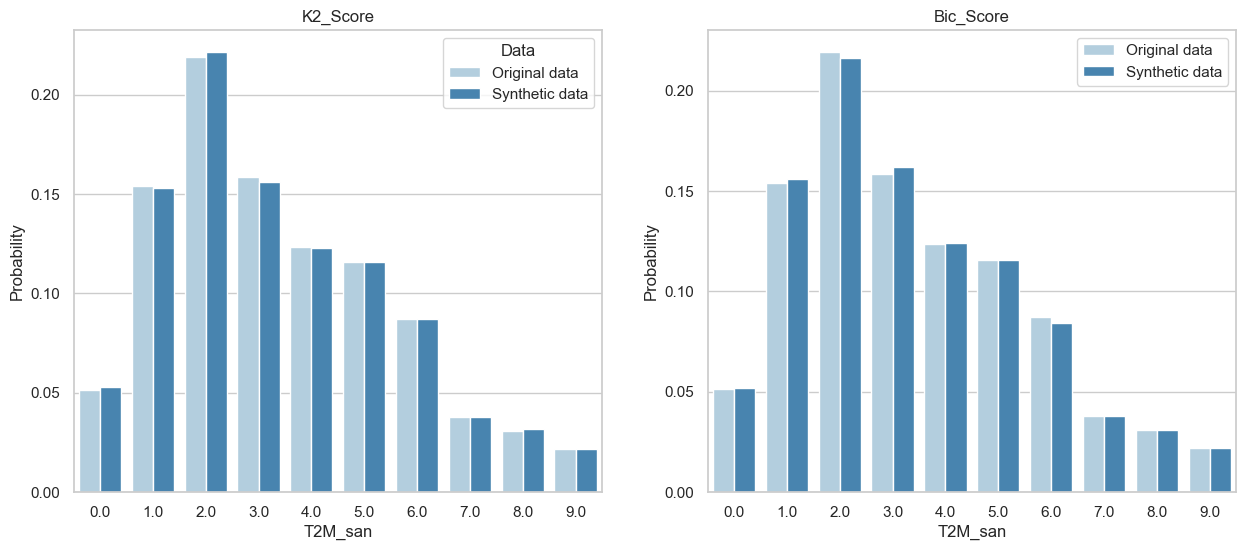

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

draw_comparative_hist('T2M_san', df_transformed, sample_K2, axes=axes[0])
draw_comparative_hist('T2M_san', df_transformed, sample_Bic, axes=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

In [41]:
sample_K2[sample_K2.columns] = discretizer.inverse_transform(sample_K2[sample_K2.columns].values)
sample_Bic[sample_Bic.columns] = discretizer.inverse_transform(sample_Bic[sample_Bic.columns].values)

In [42]:
sample_K2.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
sample_Bic.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

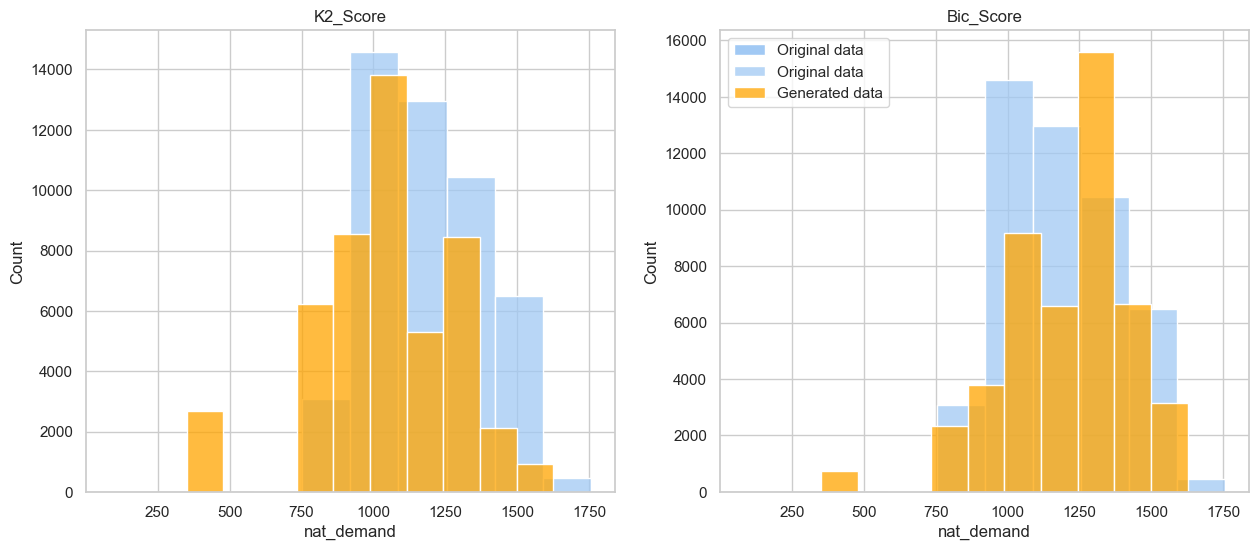

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df['nat_demand'], label='Original data', ax=axes[0], bins=10)
sns.histplot(sample_K2['1'], label='Generated data', color='orange', ax=axes[0], bins=10)

sns.histplot(df['nat_demand'], label='Original data', ax=axes[1], bins=10)
sns.histplot(sample_Bic['1'], label='Generated data', color='orange', ax=axes[1], bins=10)

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

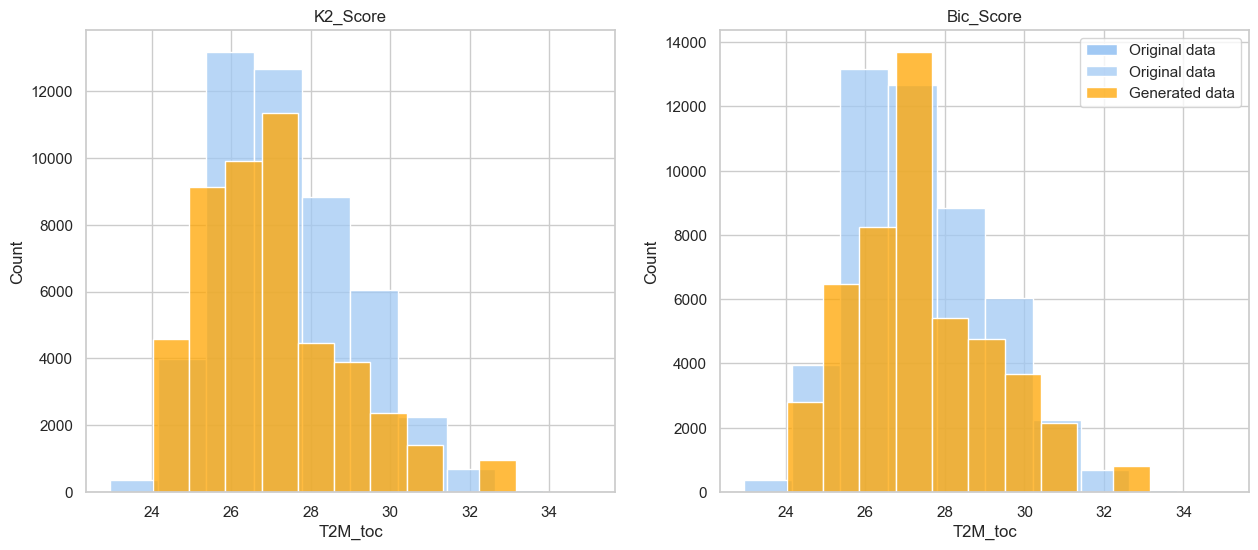

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df['T2M_toc'], label='Original data', ax=axes[0], bins=10)
sns.histplot(sample_K2['2'], label='Generated data', color='orange', ax=axes[0], bins=10)

sns.histplot(df['T2M_toc'], label='Original data', ax=axes[1], bins=10)
sns.histplot(sample_Bic['2'], label='Generated data', color='orange', ax=axes[1], bins=10)

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

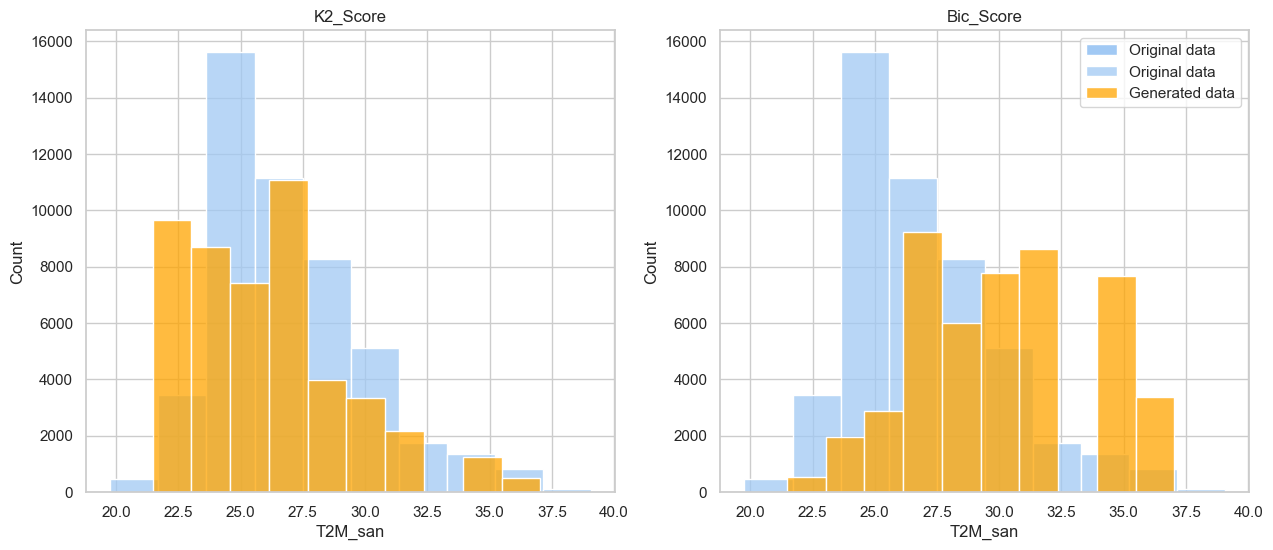

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df['T2M_san'], label='Original data', ax=axes[0], bins=10)
sns.histplot(sample_K2['5'], label='Generated data', color='orange', ax=axes[0], bins=10)

sns.histplot(df['T2M_san'], label='Original data', ax=axes[1], bins=10)
sns.histplot(sample_Bic['5'], label='Generated data', color='orange', ax=axes[1], bins=10)

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()